# Project 3 - Subreddit posts web scraping & classification

## Importing of Libraries

In [2]:
import pandas as pd
import numpy as np
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup  
from nltk.corpus import stopwords
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc, hinge_loss

## Self-defined functions used in the project

### F1 - Function to save subreddit page .json locally as .json file

In [3]:
def reddit_to_json(url, name):
    headers = {'User-agent':'lrqkv1'}
    posts = []
    after = None
    for i in range(40):
        print(i)
        if after == None:
            params = {}
        else: 
            params = {'after':after}
        url = url
        res = requests.get(url, headers=headers, params=params)
        if res.status_code == 200:
            the_json = res.json()
            posts.extend(the_json['data']['children'])
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(1)
    df_posts = pd.DataFrame(posts)
    df_posts.to_json(f'./Datasets/{name}.json')

### F2 - Function to clean text

In [4]:
def text_to_words(raw_text):
    review_text = BeautifulSoup(raw_text).get_text()
    
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    words = letters_only.lower().split()

    stops = set(stopwords.words('english'))
    
    meaningful_words = [w for w in words if not w in stops]
    
    stemmer = SnowballStemmer(language='english')
    token_stem = [stemmer.stem(e) for e in meaningful_words]
    
    lemmatizer = WordNetLemmatizer()
    token = [lemmatizer.lemmatize(e) for e in token_stem]
    
    return(" ".join(token))

### F3 - Function to plot a barchart (words in subreddit posts against frequency)

In [5]:
def top_text_plot(df, title, corpus, n=None, color='bwr'):
    vec = TfidfVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    common_words = words_freq[:n]
    df = pd.DataFrame(common_words, columns = ['Text', 'Count'])
    ax = df.groupby('Text').sum()['Count'].sort_values(ascending=False).plot(kind='bar',
                                                                             figsize = (12,4),
                                                                             cmap = color,
                                                                             rot = 0,
                                                                             fontsize = 11)
    ax.set_title(f'Top {n} words in {title} subreddit posts', fontsize = 14)
    ax.set_xlabel("Text", fontsize = 12)
    ax.set_ylabel("Frequency", fontsize = 12)

### F4 - Function to run Gridsearch to determine optimal Tvec features

In [1]:
def gs_model_opt(model, X_train, X_test, y, output=2):
    pipe = Pipeline([
        ("tvec",TfidfVectorizer()),
        model
    ])

    pipe_params = {
        'tvec__max_features': [10, 50, 100, 500, 1500, 2000, 3500, 5000],
        'tvec__min_df': [1,3,8,15],
        'tvec__max_df': [0.1, 0.25, 0.35, 0.45, 0.55],
        'tvec__ngram_range': [(1,1),(1,2),(1,3)]
                }
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=2)
    gs.fit(X_train, y)
    print(f'Gridsearch best score is: {gs.best_score_}\n')
    print(f'Best params are: {gs.best_params_}\n')
    print(f'Train score with opt features is: {gs.score(X_train, y)}\n')
    
    if output == 1:
        return gs.predict(X_test)
    elif output == 2:
        return gs.predict(X_test), gs.predict_proba(X_test)

### F5 - Function to plot a Confusion Matrix

In [7]:
def cm_plotter(y_hat, y_test, model_name):
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(y_test))
    plt.xticks(tick_marks, y_test, fontsize = 11)
    plt.yticks(tick_marks, y_hat, va="center", fontsize = 11)
    sns.heatmap((y_hat), annot=True ,fmt='g', linewidths=.5, linecolor='w', cmap='Accent_r')
    plt.title(f'Confusion matrix for the {model_name} model')
    plt.ylabel('Actual\n')
    plt.xlabel('\nPredicted')

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

### F6 - Function to plot a ROC Curve

In [59]:
def roc(probas, predict, true, title, step=0.01):
    probas = probas[:,1]
    true = true.values
    assert(len(probas) == len(true))
    TPRs = []
    FPRs = []
    
    for i in np.arange(0.0,1.0,step):
        preds_class = probas > i
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)):
            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
      
        TPR = TP/(TP + FN)
        FPR = FP/(FP + TN)
        TPRs.append(TPR)
        FPRs.append(FPR)
        
        fpr, tpr = roc_curve(y_test, predict)
        area = auc(fpr, tpr)
         
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange", label=f'ROC curve (area = {area:.2f})')
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title(f'ROC Curve for the {title} classifier')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.legend(loc="lower right")
    plt.show();

    return TPRs, FPRs, area

## 1) Data Collection & Exploration

### 1.1 - Subreddit selection

<span style="color:blue">'r/oculus' and 'r/Vive' were the subreddits selected, and the corresponding urls are:</span>
- https://www.reddit.com/r/oculus/
<br><br>
- https://www.reddit.com/r/Vive/

### 1.2 - Initial exploration of Oculus subreddit
<span style="color:blue">Defining the subreddit url and requesting it as a .json file:</span>

In [9]:
url = 'https://www.reddit.com/r/oculus.json'

#Reddit blocks the default python user agent, therefore a unique user had to be defined to request the reddit page.
headers = {'User-agent':'lrqkv1'}

res = requests.get(url, headers=headers)
res.status_code

200

<span style="color:blue">Exploring the keys and values of the .json:</span>

In [10]:
the_json = res.json()

sorted(the_json.keys())

['data', 'kind']

<span style="color:blue">the first level of the nested dictionary contains 2 keys, 'data' and 'kind',</span>

In [11]:
the_json['kind']

'Listing'

<span style="color:blue">'listing' is the only value for 'kind',</span>

In [12]:
the_json['data']

{'modhash': '',
 'dist': 27,
 'children': [{'kind': 't3',
   'data': {'approved_at_utc': None,
    'subreddit': 'oculus',
    'selftext': "^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.|**Rift S**|**Quest**|**Go**\n---|---|----|----\n**Display**|LCD (RGB stripe)|OLED (pentile matrix)|LCD (RGB stripe)\n**Resolution&amp;nbsp;(per&amp;nbsp;eye)**|1280 × 1440 @ 80 Hz|1440 × 1600 @ 72 Hz|1280 × 1440 @ 72 Hz\n**Optimal IPD**|61.5 - 65.5&amp;nbsp;mm (software)|56 - 74&amp;nbsp;mm (hardware)|61.5 - 65.5&amp;nbsp;mm (software)\n**Audio**|Integrated speakers, 3.5mm headphone jack |Integrated speakers, 3.5mm headphone jacks|Integrated speakers, 3.5mm headphone jack \n**Controllers**|Thumbsticks, buttons, triggers (left &amp; right pair)|Thumbsticks, buttons, triggers (left &amp; right pair)|Touchpad, buttons, trigger (single ambidextrous)\n**Tracking**|6 DOF (IMU + 5 cameras)|6 DOF (IMU + 4 cameras)|3 DOF (IMU)\n**Finger Tracking**|Capsense|Capsense, optical (2020)|None\n**Headband**|Halo band|Rigid 

<span style="color:blue">while the value for the key 'data' is another dictionary, a for loop is used to iterate over it to print out the keys and values within:</span>

In [13]:
for i in the_json['data'].keys():
    print(f"{i}: {the_json['data'][i]}\n")

modhash: 

dist: 27

children: [{'kind': 't3', 'data': {'approved_at_utc': None, 'subreddit': 'oculus', 'selftext': "^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.|**Rift S**|**Quest**|**Go**\n---|---|----|----\n**Display**|LCD (RGB stripe)|OLED (pentile matrix)|LCD (RGB stripe)\n**Resolution&amp;nbsp;(per&amp;nbsp;eye)**|1280 × 1440 @ 80 Hz|1440 × 1600 @ 72 Hz|1280 × 1440 @ 72 Hz\n**Optimal IPD**|61.5 - 65.5&amp;nbsp;mm (software)|56 - 74&amp;nbsp;mm (hardware)|61.5 - 65.5&amp;nbsp;mm (software)\n**Audio**|Integrated speakers, 3.5mm headphone jack |Integrated speakers, 3.5mm headphone jacks|Integrated speakers, 3.5mm headphone jack \n**Controllers**|Thumbsticks, buttons, triggers (left &amp; right pair)|Thumbsticks, buttons, triggers (left &amp; right pair)|Touchpad, buttons, trigger (single ambidextrous)\n**Tracking**|6 DOF (IMU + 5 cameras)|6 DOF (IMU + 4 cameras)|3 DOF (IMU)\n**Finger Tracking**|Capsense|Capsense, optical (2020)|None\n**Headband**|Halo band|Rigid strap|Elastic strap\n*

<span style="color:blue">The value for the key 'children' contains the data required(posts, title & subreddit name) to train our model:</span>

In [14]:
the_json['data']['children']

[{'kind': 't3',
  'data': {'approved_at_utc': None,
   'subreddit': 'oculus',
   'selftext': "^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.|**Rift S**|**Quest**|**Go**\n---|---|----|----\n**Display**|LCD (RGB stripe)|OLED (pentile matrix)|LCD (RGB stripe)\n**Resolution&amp;nbsp;(per&amp;nbsp;eye)**|1280 × 1440 @ 80 Hz|1440 × 1600 @ 72 Hz|1280 × 1440 @ 72 Hz\n**Optimal IPD**|61.5 - 65.5&amp;nbsp;mm (software)|56 - 74&amp;nbsp;mm (hardware)|61.5 - 65.5&amp;nbsp;mm (software)\n**Audio**|Integrated speakers, 3.5mm headphone jack |Integrated speakers, 3.5mm headphone jacks|Integrated speakers, 3.5mm headphone jack \n**Controllers**|Thumbsticks, buttons, triggers (left &amp; right pair)|Thumbsticks, buttons, triggers (left &amp; right pair)|Touchpad, buttons, trigger (single ambidextrous)\n**Tracking**|6 DOF (IMU + 5 cameras)|6 DOF (IMU + 4 cameras)|3 DOF (IMU)\n**Finger Tracking**|Capsense|Capsense, optical (2020)|None\n**Headband**|Halo band|Rigid strap|Elastic strap\n**Weight**|500 g|571 g|4

<span style="color:blue">'subreddit', 'selftext' & 'title' are the keys with the values we want to extract.</span>

In [15]:
#reddit_to_json('https://www.reddit.com/r/oculus.json', 'subred_oculus')

In [16]:
#reddit_to_json('https://www.reddit.com/r/Vive.json', 'subred_Vive')

<span style="color:blue">utilising the pre-defined function(F1), jsons from the respective subreddits were pulled and saved as a json file locally.</span>

### 1.3 - Loading the local .json files of the 2 subreddits

In [17]:
# Defining the paths of the subreddit .json files
oculus_path = "./Datasets/subred_oculus.json"
vive_path = "./Datasets/subred_Vive.json"

In [18]:
# Importing the .json files as a json
oculus_json = pd.read_json(oculus_path)
vive_json = pd.read_json(vive_path)

In [19]:
# Exploring the keys within the oculus .json
oculus_json.data[0].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'thumbnail', 'edited', 'author_flair_css_class', 'steward_reports', 'author_flair_richtext', 'gildings', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comments', 'selftext_html', 'likes', 'suggested_sort', 'banned_at_utc', 'view_count', 'archived', 'no_follow', '

In [20]:
# Converting the json files to a pandas DataFrame to work with
oculus_df = pd.DataFrame(list(oculus_json.data))
vive_df = pd.DataFrame(list(vive_json.data))

In [21]:
# Selecting the features that contain text to use for training a classification model
oculus_df = oculus_df[['title','selftext','subreddit']]
vive_df = vive_df[['title','selftext','subreddit']]

## 2) Data Cleaning

### 2.1 - Checking for null values within both dataframes

In [22]:
print(oculus_df.isna().sum())
print(vive_df.isna().sum())

title        0
selftext     0
subreddit    0
dtype: int64
title        0
selftext     0
subreddit    0
dtype: int64


### 2.2 - Merging title and selftext into a single column

In [23]:
oculus_df['fin_text'] = oculus_df['selftext'] + oculus_df['title']
vive_df['fin_text'] = vive_df['selftext'] + vive_df['title']

### 2.3 Calling on the cleaning function (F2) to process the data

In [24]:
oculus_text = []
vive_text = []

for element in oculus_df['fin_text']:
    oculus_text.append(text_to_words(element))

for element in vive_df['fin_text']:
    vive_text.append(text_to_words(element))

### 2.4 Returning the text files back to the 'fin_text' column

In [25]:
oculus_df['fin_text'] = pd.Series(oculus_text)
vive_df['fin_text'] = pd.Series(vive_text)

<span style="color:blue">Since the it is only necessary to 

### 2.5 Concatenating both dataframes

In [26]:
reddit_df = pd.concat([oculus_df, vive_df], axis = 0)

In [27]:
reddit_df['vive'] = reddit_df.subreddit.map({'oculus':0, 'Vive':1})

In [28]:
reddit_df.reset_index(inplace=True)

### 2.6 Dropping redundant columns

In [29]:
reddit_df.drop(['index', 'title', 'selftext', 'subreddit'], axis=1, inplace=True)

In [30]:
reddit_df.head()

,fin_text,vive
0,hello guy welcom week game experi recommend th...,0
1,clear high volum topic much request sticki thr...,0
2,year ago way back first experienc vr form goog...,0
3,built whole room around vr foldabl bed wall mo...,0
4,peopl said worth happi tri wow sharp awesom ev...,0


## 3) Train Test Split

In [31]:
X = reddit_df[['fin_text']]
y = reddit_df['vive']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

## 4) Data Visualisation

### 4.1 - Using Tfidf to vectorize the subreddit text into feature columns

In [33]:
tvec = TfidfVectorizer()

In [34]:
oculus_tvec = pd.DataFrame(tvec.fit_transform(oculus_df['fin_text']).toarray(), columns = tvec.get_feature_names())
vive_tvec = pd.DataFrame(tvec.transform(vive_df['fin_text']).toarray(), columns = tvec.get_feature_names())

### 4.2 - Bar Plot to show the top 30 words by frequency

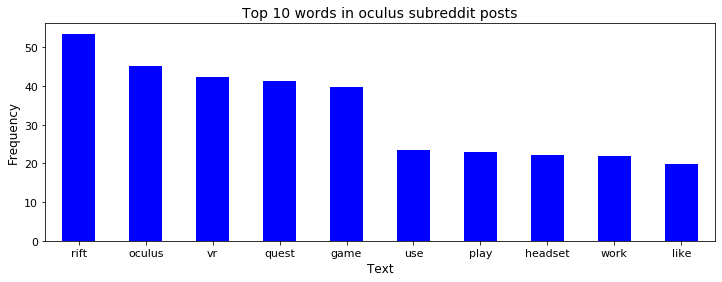

In [35]:
top_text_plot(oculus_tvec, 'oculus', oculus_df['fin_text'], 10)

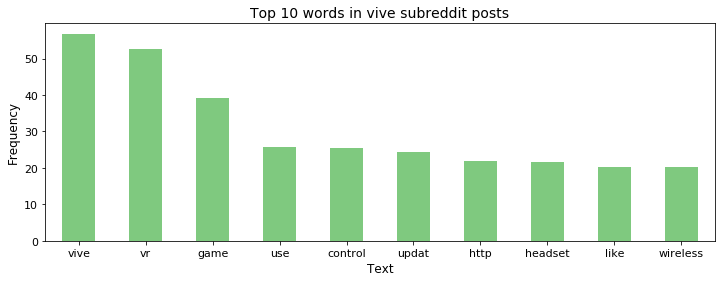

In [36]:
top_text_plot(vive_tvec, 'vive', vive_df['fin_text'], 10, 'Accent')

<span style="color:blue">
Some similarities can be seen between the top 20 words of both subreddits:
- "vr"
- "game"
- "use"
- "play"

it can be infered that both subreddits are used to chat about gaming activities frequently, and gaming keywords may not be a good feature for classifying these posts.

Word differences between the subreddits include:
- "rift"
- "oculus"

- "vive"
- "htc"
- "wireless"

these words may play a larger role in assisting the model to classify posts from the 2 subreddits.
</span>

## 5) Pipeline for Model Fitting & Gridsearch Hyperparameter Tuning

### 5.1 - Determining the range of parameters to search within

In [37]:
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['fin_text']).toarray(), columns = tvec.get_feature_names())

### - max_features

In [38]:
print(f"Training dataframe has {X_train_tvec.shape[1]} features, therefore the max_features value should lie within the range of 0 and this value")

Training dataframe has 5355 features, therefore the max_features value should lie within the range of 0 and this value


### - max_df

Text(0, 0.5, 'Mean')

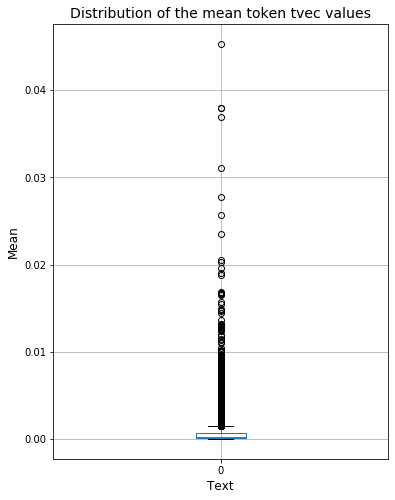

In [39]:
ax = pd.DataFrame(X_train_tvec.mean(axis='rows')).boxplot(figsize = (6, 8))

ax.set_title(f'Distribution of the mean token tvec values', fontsize = 14)
ax.set_xlabel("Text", fontsize = 12)
ax.set_ylabel("Mean", fontsize = 12)

<span style="color:blue">the range of max_df values was selected from intervals inbetween the min and max of the distribution.</span>

### 5.2 -  Bernoulli NB

In [42]:
nb_predict, nb_predict_proba = gs_model_opt(("nb",BernoulliNB()), X_train['fin_text'], X_test['fin_text'], y_train, output =2)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.0min


Gridsearch best score is: 0.8148148148148148

Best params are: {'tvec__max_df': 0.45, 'tvec__max_features': 10, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}

Train score with opt features is: 0.8168350168350168



[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.5min finished


<span style="color:blue">
The gridsearch best score and training score were very close, indicting that the selected best params were close to the true best param values. The score of 81% for the training data also indicated a slight overfit of the model.
</span>

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_predict).ravel()
print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn)}\n")
print(f"Sensitivity: {tp/(tp+fn)}\n")
print(f"Specificity: {tn/(tn+fp)}\n")

Accuracy: 0.8181818181818182

Sensitivity: 0.9512195121951219

Specificity: 0.6867469879518072



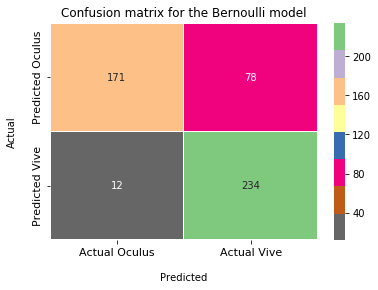

In [44]:
nb_cm_df = pd.DataFrame(confusion_matrix(y_test, nb_predict),
                        columns=('Actual Oculus','Actual Vive'),
                        index=('Predicted Oculus','Predicted Vive'))

cm_plotter(nb_cm_df, y_test, 'Bernoulli')

<span style="color:blue">
The Bernoulli model appears to do a decent job at classifying the test data accurately, with an accuracy of 81% and only 12 misclassified Oculus subreddit posts(95% sensitivity). However 78 Vive subreddit posts were misclassified, resulting in a specificity of 68%.
</span>

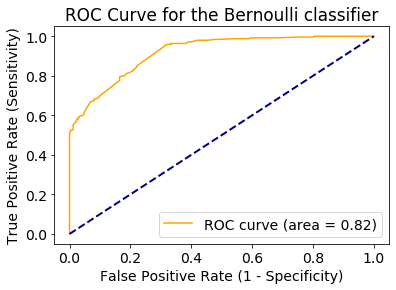

In [60]:
nb_TPRs, nb_FPRs, nb_area, nb_thresholds = roc(probas = nb_predict_proba,
                                predict = nb_predict,
                                true = y_test,
                                title = 'Bernoulli',
                                step=0.0001);

<span style="color:blue">
The ROC curve for the Bernoulli model had an area under curve of 0.82, which represented a high accuracy in its classification of the subreddit posts.
</span>

### 5.3 -  Logistic Regression 

In [46]:
lr_predict, lr_predict_proba = gs_model_opt(("lr",LogisticRegression(solver='lbfgs')), X_train['fin_text'], X_test['fin_text'], y_train, output =2)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.5min finished


Gridsearch best score is: 0.8538720538720539

Best params are: {'tvec__max_df': 0.45, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}

Train score with opt features is: 0.9441077441077441



<span style="color:blue">
The gridsearch best score and training score was 10% apart, indicting that the selected best params were not representative of the true best param values. The score of 94% for the training data also indicated a high overfit of the model.
</span>

In [47]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_predict).ravel()
print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn)}\n")
print(f"Sensitivity: {tp/(tp+fn)}\n")
print(f"Specificity: {tn/(tn+fp)}\n")

Accuracy: 0.8767676767676768

Sensitivity: 0.926829268292683

Specificity: 0.8273092369477911



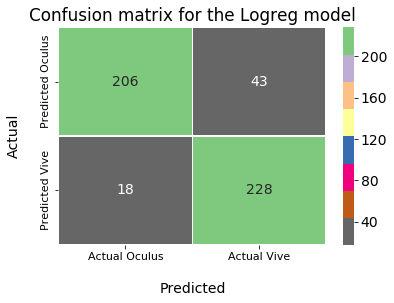

In [48]:
lr_cm_df = pd.DataFrame(confusion_matrix(y_test, lr_predict),
                        columns=('Actual Oculus','Actual Vive'),
                        index=('Predicted Oculus','Predicted Vive'))

cm_plotter(lr_cm_df, y_test, 'Logreg')

<span style="color:blue">
The Logistic Regression model does a good job at classifying the test data accurately, with an accuracy of 87% and a sensitivity, specificity of 92% and 82% respectively. This shows that the model is able to consistantly classify the reddit test data to the correct category.
</span>

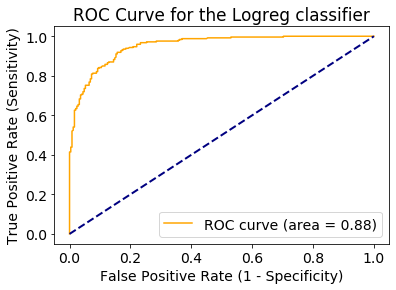

In [61]:
lr_TPRs, lr_FPRs, lr_area, lr_thresholds = roc(probas = lr_predict_proba,
                                predict = lr_predict,
                                true = y_test,
                                title = 'Logreg',
                                step=0.0001);

<span style="color:blue">
The ROC curve for the Logistic Regression model had an area under curve of 0.88, the highest of the 3 models tested, indicating its accuracy at classifying the subreddit posts correctly.
</span>

### 5.4 -  Random Forest

In [50]:
rf_predict, rf_predict_proba = gs_model_opt(("rf",RandomForestClassifier(n_estimators = 100)),  X_train['fin_text'], X_test['fin_text'], y_train, output=2)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  3.7min finished


Gridsearch best score is: 0.8693602693602693

Best params are: {'tvec__max_df': 0.55, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}

Train score with opt features is: 0.9959595959595959



<span style="color:blue">
The training score with the gridsearched optimal features of 99% indicated a highly overfit model.
</span>

In [51]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_predict).ravel()
print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn)}\n")
print(f"Sensitivity: {tp/(tp+fn)}\n")
print(f"Specificity: {tn/(tn+fp)}\n")

Accuracy: 0.8686868686868687

Sensitivity: 0.9227642276422764

Specificity: 0.8152610441767069



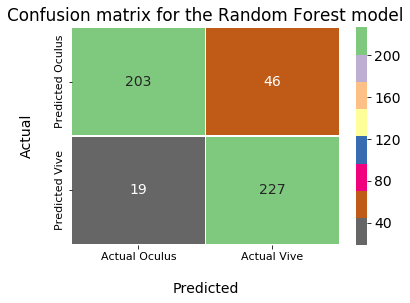

In [52]:
rf_cm_df = pd.DataFrame(confusion_matrix(y_test, rf_predict),
                        columns=('Actual Oculus','Actual Vive'),
                        index=('Predicted Oculus','Predicted Vive'))

cm_plotter(rf_cm_df, y_test, 'Random Forest')

<span style="color:blue">
Performing only slightly more inaccurately as compared to the Logistic Regression model (6 fewer accurately predicted oculus words, and 6 more inaccurately predicted Vive words), the Random Forest classifier did show a high accuracy for predicting subreddit posts.
</span>

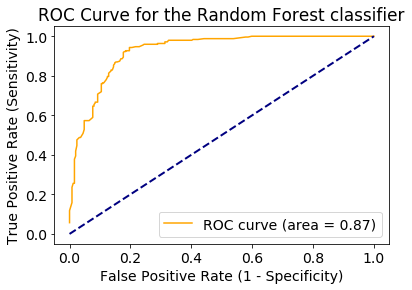

In [62]:
rf_TPRs, rf_FPRs, rf_area, rf_thresholds = roc(probas = rf_predict_proba,
                                predict = rf_predict,
                                true = y_test,
                                title = 'Random Forest',
                                step=0.0001);

<span style="color:blue">
Performing only 0.01 lower than the Logistic Regression model, the Random Forest classifier also performed well.
</span>

### 5.5 -  Combined ROC Curve

In [66]:
nbfpr, tpr, nbthresholds = roc_curve(y_test, nb_predict)

In [67]:
lrfpr, tpr, lrthresholds = roc_curve(y_test, lr_predict)

In [68]:
rffpr, rftpr, rfthresholds = roc_curve(y_test, rf_predict)

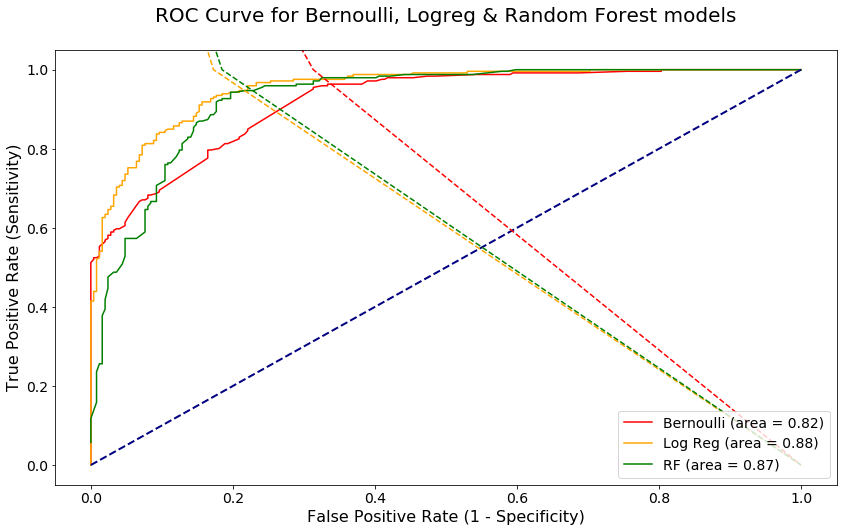

In [72]:
plt.figure(figsize = (14,8))

plt.plot(nb_FPRs, nb_TPRs, color="red", label=f'Bernoulli (area = {nb_area:.2f})')
plt.plot(lr_FPRs, lr_TPRs, color="orange", label=f'Log Reg (area = {lr_area:.2f})')
plt.plot(rf_FPRs, rf_TPRs, color="green", label=f'RF (area = {rf_area:.2f})')

plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.plot(nbfpr, nb_thresholds,linestyle='dashed', color='red')
plt.plot(lrfpr, lr_thresholds, linestyle='dashed', color='orange')
plt.plot(rffpr, rf_thresholds, linestyle='dashed', color='green')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.title(f'ROC Curve for Bernoulli, Logreg & Random Forest models\n', fontsize = 20)
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize = 16)
plt.ylabel("True Positive Rate (Sensitivity)", fontsize = 16)
plt.legend(loc="lower right")
plt.show();

<span style="color:blue">From this ROC curve, where the 3 models Bernoulli, Logistic Regression and Random Forest are displayed in the same figure, it is clear that Logistic regression (area under curve of 0.88) performs the best at classifying the subreddit posts.</span>

Text(0, 0.5, 'Frequency')

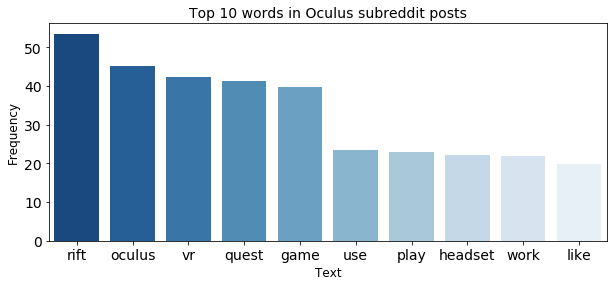

In [55]:
vec = TfidfVectorizer(stop_words = 'english').fit(oculus_df['fin_text'])
bag_of_words = vec.transform(oculus_df['fin_text'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
common_words = words_freq[:10]
df = pd.DataFrame(common_words, columns = ['Text', 'Count'])
df2 = pd.DataFrame(df.groupby('Text').sum()['Count'].sort_values(ascending=False))
plt.figure(figsize=(10, 4))
ax = sns.barplot(df2.index, df2['Count'], palette="Blues_r")
ax.set_title(f'Top 10 words in Oculus subreddit posts', fontsize = 14)
ax.set_xlabel("Text", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)

Text(0, 0.5, 'Frequency')

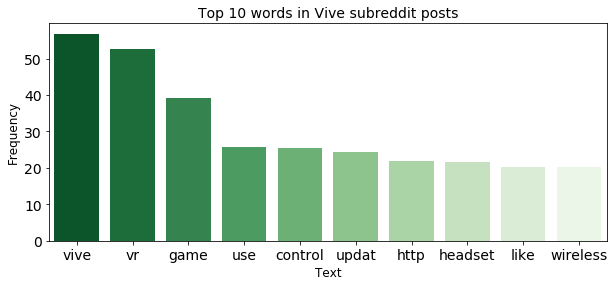

In [56]:
vec = TfidfVectorizer(stop_words = 'english').fit(vive_df['fin_text'])
bag_of_words = vec.transform(vive_df['fin_text'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
common_words = words_freq[:10]
df = pd.DataFrame(common_words, columns = ['Text', 'Count'])
df2 = pd.DataFrame(df.groupby('Text').sum()['Count'].sort_values(ascending=False))
plt.figure(figsize=(10, 4))

ax = sns.barplot(df2.index, df2['Count'], palette="Greens_r")
ax.set_title(f'Top 10 words in Vive subreddit posts', fontsize = 14)
ax.set_xlabel("Text", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)